In [1]:
import torch
import torchvision
from torchvision import transforms, datasets

transform=transforms.Compose([transforms.ToTensor()
                              ,transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset=torchvision.datasets.CIFAR10(root="./data", train=True, download =True, transform=transform)

trainloader=torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)

testset=torchvision.datasets.CIFAR10(root="./data", train=False, download =True, transform=transform)

testloader=torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=0)

classes=("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


horse   car  bird   car


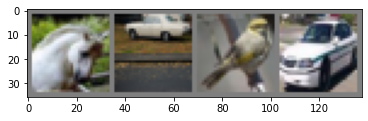

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img=img/2+0.5
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show

dataiter=iter(trainloader)
images, labels =dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(" ".join("%5s" % classes [labels[j]] for j in range(4)))

In [44]:
import torch.nn as nn 
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(3,10,5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(10,16,5)
        self.fc1=nn.Linear(16*5*5, 120)
        self.fc2=nn.Linear(120, 84)
        self.fc3=nn.Linear(84, 10)
        
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,16*5*5)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        
        return x
        
net=Net()
    

In [45]:
import torch.optim as optim

loss_function=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)

In [46]:
EPOCHS=2
for epoch in range(EPOCHS):
    
    running_loss=0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels= data
        optimizer.zero_grad()
        outputs=net(inputs)
        loss=loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss+= loss.item()
        if i%2000==1999:
            print("[%d,%5d] loss: %.3f" % (epoch+1, i+1, running_loss/2000))
            running_loss = 0.0
print("Finished Training")

[1, 2000] loss: 2.209
[1, 4000] loss: 1.854
[1, 6000] loss: 1.632
[1, 8000] loss: 1.549
[1,10000] loss: 1.457
[1,12000] loss: 1.431
[2, 2000] loss: 1.355
[2, 4000] loss: 1.325
[2, 6000] loss: 1.315
[2, 8000] loss: 1.292
[2,10000] loss: 1.253
[2,12000] loss: 1.238
Finished Training


In [47]:
PATH="./cifar_net.pth"
torch.save(net.state_dict(), PATH)

GroundTruth:    cat  ship  ship plane


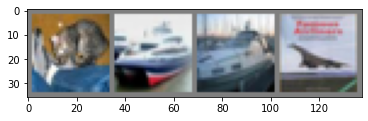

In [48]:
dataiter=iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print("GroundTruth: " , " ".join("%5s" % classes[labels[j]] for j in range(4)))

In [49]:
net=Net()
net.load_state_dict(torch.load(PATH))
outputs=net(images)

In [50]:
_,predicted=torch.max(outputs,1)
print("Predicted: " , " ".join("%5s" % classes[predicted[j]] for j in range(4)) )

Predicted:    cat  ship   car plane


In [52]:
correct=0
total=0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs= net(images)
        _, predicted=torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()
print("Accuracy of the network on the 10000 test images: %d %%" %(100*correct/total))

Accuracy of the network on the 10000 test images: 56 %


In [53]:
class_correct=list(0. for i in range(10))
class_total=list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels =data
        outputs= net(images)
        _, predicted=torch.max(outputs, 1)
        c= (predicted==labels).squeeze()
        for i in range(4):
            label=labels[i]
            class_correct[label]+= c[i].item()
            class_total[label]+=1

for i in range(10):
    print("Accuracy of %5s : %2d %%" %(classes[i], 100*class_correct[i]/class_total[i]))

Accuracy of plane : 57 %
Accuracy of   car : 68 %
Accuracy of  bird : 32 %
Accuracy of   cat : 23 %
Accuracy of  deer : 58 %
Accuracy of   dog : 62 %
Accuracy of  frog : 78 %
Accuracy of horse : 52 %
Accuracy of  ship : 59 %
Accuracy of truck : 75 %


In [54]:
device=torch.device("cuda:0" if torch.cuda.is_available() else"cpu")
print(device)

cpu


In [55]:
net.to(device)
inputs, labels = data[0].to(device), data[1].to(device)